## **Import Libraries**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.metrics import error_rate

# **Stage 1**

## **Data Setup & Preview** 

In [9]:
data_path = Path.home()/'notebooks/programming/data/watch_bot'
csv_path = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/file_attribs.csv'

In [10]:
df = pd.read_csv(csv_path)
df = df[['name', 'dial_visibility']]
df = df.astype({'dial_visibility':'int'})
df.head(), df.dtypes

(                                                name  dial_visibility
 0  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 1  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 2  nomos_1/nomos/_without_model/nomos_@_the_loupe...                0
 3  nomos_1/nomos/_without_model/nomos_beta_11156_...                1
 4  nomos_1/nomos/_without_model/nomos_beta_11156_...                1,
 name               object
 dial_visibility     int64
 dtype: object)

In [11]:
bs = 64
img_size = 128
xform = get_transforms(flip_vert=True)

In [12]:
src = (ImageList.from_df(df, data_path)
        .split_by_rand_pct()
        .label_from_df())

In [13]:
data = (src.transform(tfms=xform, size=img_size, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [14]:
print(f'{data.train_ds}\n\n{data.valid_ds}')


LabelList (9579 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,1,1,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot

LabelList (2394 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot


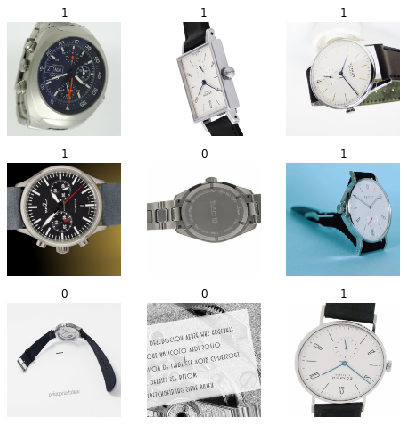

In [15]:
data.show_batch(rows=3, figsize=(6,6))

In [9]:
# TODO: resize before training - https://docs.fast.ai/vision.transform.html#resize
# look at https://nbviewer.jupyter.org/github/rsomani95/shot-type-classifier/blob/master/methodology.ipynb#Defining-Data-Transformations----

## **Training**

In [16]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


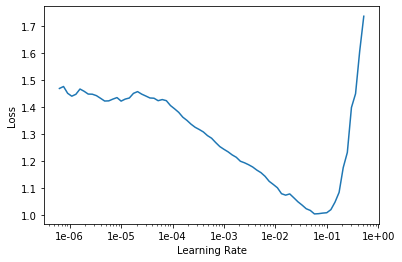

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(8, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.918992,0.509633,0.766500,01:14
1,0.664069,0.333837,0.868003,01:08
2,0.460051,0.229449,0.916040,01:08
3,0.373469,0.205335,0.934002,01:09
4,0.310271,0.168922,0.942774,01:08
5,0.288848,0.143153,0.949457,01:09
6,0.254363,0.130007,0.956140,01:08
7,0.251714,0.127440,0.957393,01:09


In [15]:
learn.save('stage_1')

## **Interpreting**

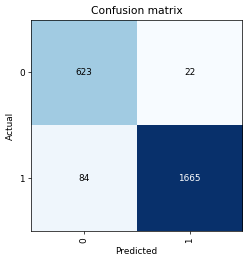

In [10]:
learn.load('stage_1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=64)

In [17]:
losses, idxs = interp.top_losses()
len(losses) == len(idxs) == len(data.valid_ds)

True

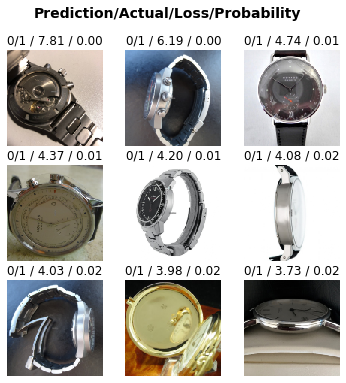

In [15]:
interp.plot_top_losses(9, figsize=(6,6))

## **Fine Tuning**

In [21]:
learn.load('stage_1');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


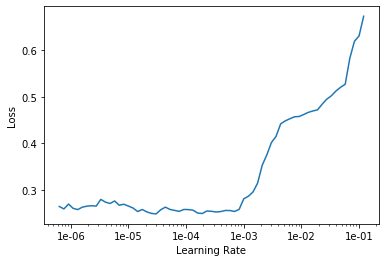

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8, slice(1e-06, 3e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.259583,0.130804,0.956140,01:25
1,0.208333,0.152517,0.956976,01:26
2,0.162355,0.107900,0.969089,01:26
3,0.111324,0.076470,0.977861,01:26
4,0.086524,0.086575,0.978279,01:25
5,0.076577,0.073838,0.980785,01:26
6,0.071685,0.072082,0.981621,01:26
7,0.065253,0.068746,0.982456,01:26


In [24]:
learn.save('stage_1_fine_tuning')

## **Interpreting**

In [17]:
learn.load('stage_1_fine_tuning');

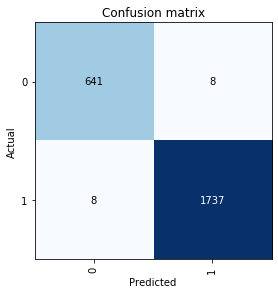

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

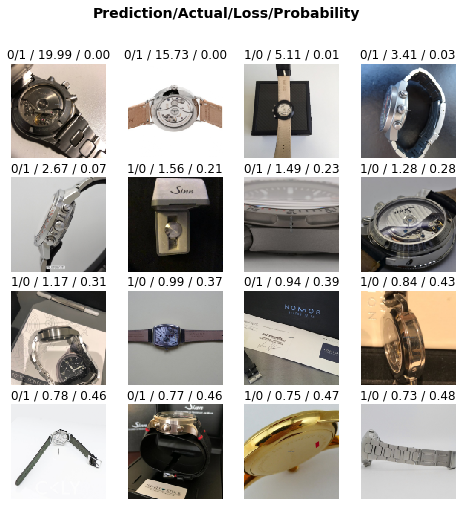

In [19]:
interp.plot_top_losses(16, figsize=(8,8))

## **Fixing wrongly labeled images**

In [20]:
losses, idxs = interp.top_losses()
print(f'{losses[:20]}\n\n{idxs[:20]}')

tensor([19.9922, 15.7344,  5.1144,  3.4096,  2.6740,  1.5593,  1.4885,  1.2776,
         1.1689,  0.9887,  0.9356,  0.8386,  0.7813,  0.7717,  0.7541,  0.7287,
         0.6455,  0.6342,  0.5106,  0.4789])

tensor([2017,  100, 1876, 2286, 1130,  817,  355,  190, 2378, 1586,  273, 1073,
         563, 1128,  103, 2364,  856,  627, 2258, 1392])


1


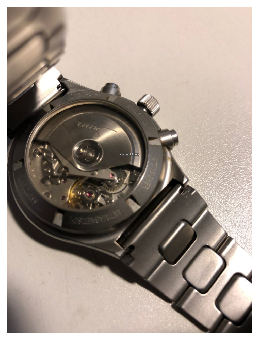

In [80]:
item_idx = 2017
print(data.valid_ds.y[item_idx])
img = data.valid_ds.x[item_idx]
img.show(figsize=(6,6))

In [63]:
top_losses_path = data.valid_ds.x[idxs[:10]].items
name_path = [file.split('watch_bot/')[1] for file in top_losses_path]
name_path

['sinn_1/sinn/144/sinn_144_gmt_st-2.jpg',
 'nomos_1/nomos/metro_neomatik/nomos_metro_neomatik_galvanized_champagne_dial_steel_leather_strap_1107_new-5.jpg',
 'sinn_1/sinn/_without_model/sinn_circle_chronograph_audi_r8-2.jpg',
 "sinn_1/sinn/144/sinn_gmt_144_world_time_automatic_aviator_steel_men's_chronograph-4.jpg",
 'sinn_1/sinn/303/sinn_chronograph_limited_edition_888__mazda__-stahl_stahl,_box+papiere-4.jpg',
 'sinn_1/sinn/203/sinn_203_edelstahl_gold-4.jpg',
 'sinn_1/sinn/_without_model/sinn__t1_ezm_14__ezm_14__titanium-4.jpg',
 'sinn_1/sinn/103/sinn_103_a_sa_fliegerchronograp_panda_103.060-7.jpg',
 'sinn_1/sinn/356/sinn_356_flieger_sa_ii_copper-3.jpg',
 'nomos_1/nomos/_without_model/nomos_lux_weissgold-4.jpg']

In [79]:
df_top_losses = df[df['name'].isin(name_path)]
df_top_losses.index.to_list()

[81, 2728, 6463, 7427, 7530, 7767, 8031, 8082, 10268, 10339]

# **Stage 2**

## **Data Setup**

In [86]:
#bs = 32
img_size = 256

In [92]:
data = (src.transform(tfms=xform, size=img_size, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [91]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [100]:
learn.load('stage_1_fine_tuning');
learn = learn.to_fp16()
learn.freeze()
learn.data = data
learn.data

ImageDataBunch;

Train: LabelList (9579 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,0,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Valid: LabelList (2394 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Test: None

## **Training**

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


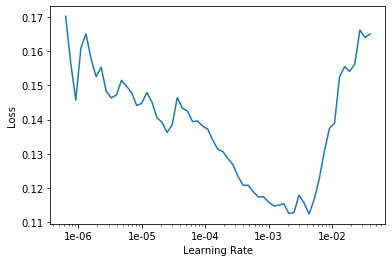

In [102]:
learn.lr_find()
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(5, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.048569,0.027024,0.990810,02:59
1,0.051541,0.031358,0.988304,03:00
2,0.057653,0.025809,0.991646,03:00
3,0.047608,0.025443,0.990393,03:00
4,0.040225,0.025458,0.991228,03:00


In [106]:
learn.save('stage_2')

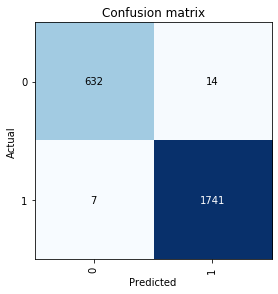

In [110]:
learn.load('stage_2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

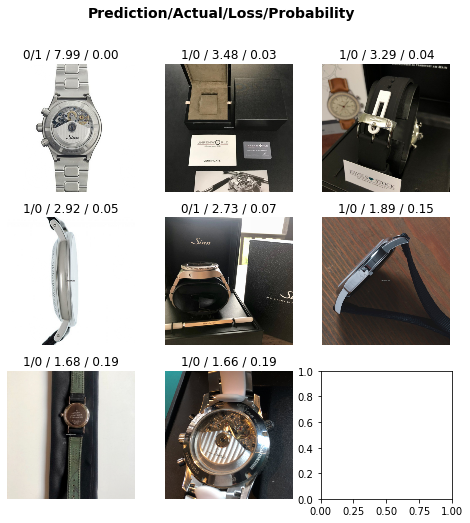

In [111]:
interp.plot_top_losses(8, figsize=(8,8))

## **Fine Tuning**

In [113]:
learn.load('stage_2');

In [116]:
learn.unfreeze()
leran = learn.to_fp16()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


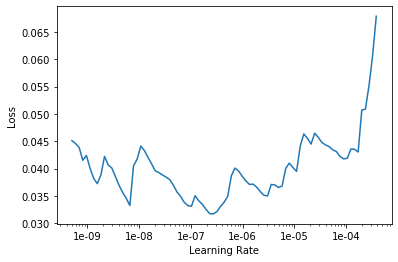

In [122]:
leran.lr_find(start_lr=1e-10, end_lr=1e-03)
learn.recorder.plot()

In [ ]:
# TODO: Re-run all cells
#       Fix wrong labeling on dataset
#       There is no need for fine tuning at this stage because we have already good accuracy. Maybe we are overfitting
#       Continue with predictions etc...